### Example of An Earlier Experiment -  Weighted Crossentropy

Model G1.16, ISIC 2017 dataset, ResNet-50	base model, Weighted Crossentropy loss function,  batch size =	16, lr = 1e-5, augmentation = Yes, top 32 layers	trainable


In [ ]:
#import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
import random

#to cater for class weighted cross entropy
from sklearn.utils import class_weight

In [ ]:
#setup for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#general Configuration
IMG_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 16
EPOCHS = 20 #early fine-tuning
LR = 1e-5
LOSS ='categorical_crossentropy'

In [ ]:
#................. Utility Functions .................

#extracts downloaded data from zip file format
def extract_zip(filename, target_path="."):
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(target_path)

#loads and preprocesses the label data (target)
def load_and_process_labels(csv_path):
    df = pd.read_csv(csv_path)
    df['new_image_id'] = df['image_id'] + ".jpg"
    df['id'] = df['melanoma'].apply(lambda x: 'mel' if x != 0.0 else 'no') + \
               df['seborrheic_keratosis'].apply(lambda x: 'seb' if x != 0.0 else 'no')
    df['label'] = df['id'].apply(lambda x: 0 if x == 'nono' else 2 if x == 'melno' else 1)
    return df

#determine the distribution of classes in the dataset
def show_class_distribution(y, title="Class Distribution"):
    unique, counts = np.unique(y, return_counts=True)
    class_labels = ['Benign (0)', 'SK (1)', 'Melanoma (2)']

    print(f"\n{title}:")
    for label, count in zip(unique, counts):
        print(f"  Class {label} ({class_labels[label]}): {count} samples")

#apply fixed augmentations to underrepresented classes
def augment_image_fixed(img, mode):
    if mode == 'flip_lr':
        img = tf.image.flip_left_right(img)
    elif mode == 'flip_ud':
        img = tf.image.flip_up_down(img)
    elif mode == 'rot90':
        img = tf.image.rot90(img, k=1)
    elif mode == 'rot180':
        img = tf.image.rot90(img, k=2)
    return img

#load and augment_images()
def load_and_augment_images(df, img_dir, seed=42):
    X_aug = []
    y_aug = []

    augment_modes = ['flip_lr', 'flip_ud', 'rot90', 'rot180']
    rng = np.random.default_rng(seed)

    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['new_image_id'])
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img.astype('float32') / 255.0

        X_aug.append(img)
        y_aug.append(row['label'])

        if row['label'] in [1, 2]:
            tf_img = tf.convert_to_tensor(img)
            for mode in augment_modes:
                aug_img = augment_image_fixed(tf_img, mode)
                X_aug.append(aug_img.numpy())
                y_aug.append(row['label'])

    #shuffle using consistent seed
    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    idx = rng.permutation(len(X_aug))  # uses np.random.Generator for reproducibility
    return X_aug[idx], y_aug[idx]

#downsamples majority classes in a DataFrame to match the target_count
def downsample_selected_classes(df, target_count=1270, labels_to_downsample=[0, 2], label_col='label', random_state=42):
    downsampled_dfs = []

    for label in df[label_col].unique():
        class_subset = df[df[label_col] == label]

        if label in labels_to_downsample and len(class_subset) > target_count:
            class_subset = class_subset.sample(n=target_count, random_state=random_state)

        downsampled_dfs.append(class_subset)

    return pd.concat(downsampled_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)

#show some augmented data samples
def show_augmented_samples(X, y, n=6):
    plt.figure(figsize=(12, 5))
    for i in range(n):
        plt.subplot(2, n // 2, i + 1)
        plt.imshow(X[i])
        plt.title(f"Label: {y[i]}")
        plt.axis("off")
    plt.suptitle('Sample data')
    plt.show()

#load the image dataset and preprocess e.g. correct color format, reszie, map labels
def load_images(df, img_dir):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['new_image_id'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            X.append(img.astype('float32') / 255.0)
            y.append(row['label'])
    return np.array(X), np.array(y)

#build the model, adding custom top layer
def build_resnet50_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    #freeze all layers by default
    base_model.trainable = False

    #unfreeze the top 32 layers (i.e., last 32 layers in the model)
    for layer in base_model.layers[-32:]:
      layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])
    return model

#training of the model
def train_model(model, X, y, class_weights):
    y_encoded = to_categorical(y, num_classes=NUM_CLASSES)

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )

    class PrintLearningRate(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            #lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
            print(f"\nEpoch {epoch + 1}: Learning rate is {lr:.6f}")

    history = model.fit(
        X, y_encoded,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        callbacks=[early_stop, lr_scheduler, PrintLearningRate()],
        shuffle=True,
        class_weight=class_weights  #for weighted categorical cross entropy
    )
    return history

#evaluate the model based pn metrics e.g. accuracy, precision, recall, sensitivity, specificity
def evaluate_model(y_true, y_pred, y_proba, class_names):
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nSensitivity and Specificity per class:")
    for i, cls in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        print(f"Class: {cls}")
        print(f"  Sensitivity: {TP / (TP + FN):.4f}")
        print(f"  Specificity: {TN / (TN + FP):.4f}")

    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    auc_macro = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
    auc_micro = roc_auc_score(y_true_bin, y_proba, average='micro', multi_class='ovr')
    auc_weighted = roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr')

    print(f"\nAUC (macro): {auc_macro:.4f}")
    print(f"AUC (micro): {auc_micro:.4f}")
    print(f"AUC (weighted): {auc_weighted:.4f}")

#show training history plot
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#mount drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

#paths -> Note replace these paths with the paths on appropriate drive e.g. Google drive
train_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Training_Data.zip"
test_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Test_v2_Data.zip"
val_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Validation_Data.zip"
train_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Training_Part3_GroundTruth.csv"
test_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
val_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Validation_Part3_GroundTruth.csv"
train_dir = "/content/ISIC-2017_Training_Data"
test_dir = "/content/ISIC-2017_Test_v2_Data"
val_dir = "/content/ISIC-2017_Validation_Data"


Mounted at /content/drive



Before Augmentation Class Distribution - Training Data:
  Class 0 (Benign (0)): 1372 samples
  Class 1 (SK (1)): 254 samples
  Class 2 (Melanoma (2)): 374 samples

Before Augmentation Class Distribution - Testing Data:
  Class 0 (Benign (0)): 393 samples
  Class 1 (SK (1)): 90 samples
  Class 2 (Melanoma (2)): 117 samples

After Augmentation - Training Data:
  Class 0 (Benign (0)): 1372 samples
  Class 1 (SK (1)): 1270 samples
  Class 2 (Melanoma (2)): 1870 samples


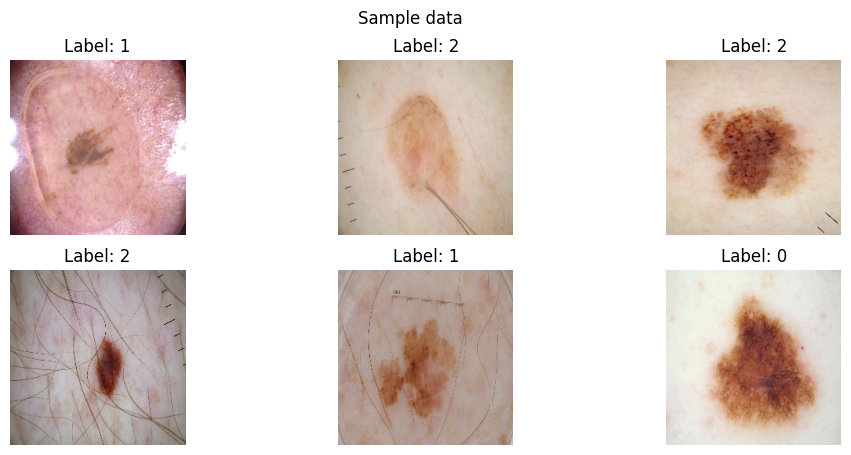


Not Augmented - Testing Data:
  Class 0 (Benign (0)): 393 samples
  Class 1 (SK (1)): 90 samples
  Class 2 (Melanoma (2)): 117 samples


In [ ]:
#extract and load
extract_zip(train_zip)
extract_zip(test_zip)
extract_zip(val_zip)
train_df = load_and_process_labels(train_csv)
test_df  = load_and_process_labels(test_csv)
val_df  = load_and_process_labels(val_csv)

#class distribution
show_class_distribution(train_df['label'].values, title="Before Augmentation Class Distribution - Training Data")
show_class_distribution(test_df['label'].values, title="Before Augmentation Class Distribution - Testing Data")

#load and augment Training Data
X_train, y_train = load_and_augment_images(train_df, train_dir,seed=SEED)

#after augmentation class distribution
show_class_distribution(y_train, title="After Augmentation - Training Data")

#show sample images after augmentation
show_augmented_samples(X_train, y_train, n=6)

X_test, y_test = load_images(test_df, test_dir)

#after class distribution
show_class_distribution(y_test, title="Not Augmented - Testing Data")



In [ ]:
#------------Downsample Benign and Melanoma to match SK (1270 samples each)------------
#create a dataframe from X_train and y_train
df_augmented = pd.DataFrame({'idx': np.arange(len(y_train)), 'label': y_train})

#downsample (only label 0 and 2)
df_downsampled = downsample_selected_classes(df_augmented, target_count=1270, labels_to_downsample=[0, 2], label_col='label', random_state=42)




After Downsampling - Training Data:
  Class 0 (Benign (0)): 1270 samples
  Class 1 (SK (1)): 1270 samples
  Class 2 (Melanoma (2)): 1270 samples


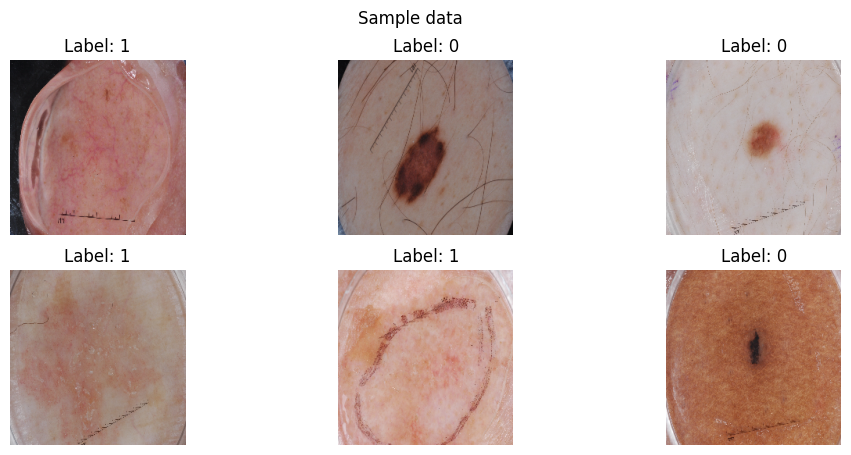

In [ ]:
#use the selected indices to get the filtered images and labels
X_train = X_train[df_downsampled['idx'].values]
y_train = y_train[df_downsampled['idx'].values]
# ---------------------------------------------------------------

#confirm class balance
show_class_distribution(y_train, title="After Downsampling - Training Data")

#show sample images
show_augmented_samples(X_test, y_test, n=6)

In [ ]:
#............... Main Execution ...............

def main():

    #--------------Categorical Weighted Cross Entropy---------------------------
    #calculate class weights from the (original/unbalanced) training DataFrame
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['label']),
        y=train_df['label'].values
    )
    class_weights = dict(enumerate(class_weights))
    print("Class Weights:", class_weights)

     #--------------------------------------------------------------------------

    #build and Train Model
    model = build_resnet50_model()

    #check which layers are trainable
    print("\nTrainable layers:")
    for layer in model.layers:
        if layer.trainable:
            print(f"  {layer.name}")

    model.summary()

    history = train_model(model, X_train, y_train, class_weights)

    #predict and evaluate
    y_proba = model.predict(X_test)
    y_pred = np.argmax(y_proba, axis=1)
    evaluate_model(y_test, y_pred, y_proba, class_names=['Benign', 'SK', 'Melanoma'])
    print(f"Balanced Accuracy (BACC): {balanced_accuracy_score(y_test, y_pred):.4f}")

    #plot training history
    plot_history(history)

    #save model and predictions
    model.save("/content/drive/MyDrive/Deep Learning/Results/skin_cancer_resnet50_model_v1.16.h5")
    pd.DataFrame({
        'Image': test_df['new_image_id'],
        'True Label': y_test,
        'Predicted Label': y_pred
    }).to_csv("/content/drive/MyDrive/Deep Learning/Results/prediction_results_v1.16.csv", index=False)



Class Weights: {0: np.float64(0.4859086491739553), 1: np.float64(2.6246719160104988), 2: np.float64(1.7825311942959001)}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

Trainable layers:
  conv5_block1_1_conv
  conv5_block1_1_bn
  conv5_block1_1_relu
  conv5_block1_2_conv
  conv5_block1_2_bn
  conv5_block1_2_relu
  conv5_block1_0_conv
  conv5_block1_3_conv
  conv5_block1_0_bn
  conv5_block1_3_bn
  conv5_block1_add
  conv5_block1_out
  conv5_block2_1_conv
  conv5_block2_1_bn
  conv5_block2_1_relu
  conv5_block2_2_conv
  conv5_block2_2_bn
  conv5_block2_2_relu
  conv5_block2_3_conv
  conv5_block2_3_bn
  conv5_block2_add
  conv5_block2_out
  conv5_block3_1_conv
  conv5_block3_1_bn
  conv5_block3_1_relu
  conv5_block3_2_conv
  conv5_block3_2_bn
  conv5_block3_2_relu
  conv5_block3_3_conv
  conv5_block3_3_bn
  conv5_block3_add
  conv5_block3_out
  global_average_pooling2d
  dense
  dropout
  dense_1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 15,501,315 (59.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3828 - loss: 1.5139
Epoch 1: Learning rate is 0.000010
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.3830 - loss: 1.5135 - val_accuracy: 0.3241 - val_loss: 1.1281 - learning_rate: 1.0000e-05
Epoch 2/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4779 - loss: 1.2694
Epoch 2: Learning rate is 0.000010
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4781 - loss: 1.2691 - val_accuracy: 0.4278 - val_loss: 1.1314 - learning_rate: 1.0000e-05
Epoch 3/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4961 - loss: 1.1666
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 3: Learning rate is 0.000005
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4963 - loss: 1.1663 - val_accuracy: 0.4528 - val_loss: 1.3352 - learning_rate: 1.0000e-05
Epoch 4/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5165 - loss: 1.0840
Epoch 4: Learning rate is 0.00

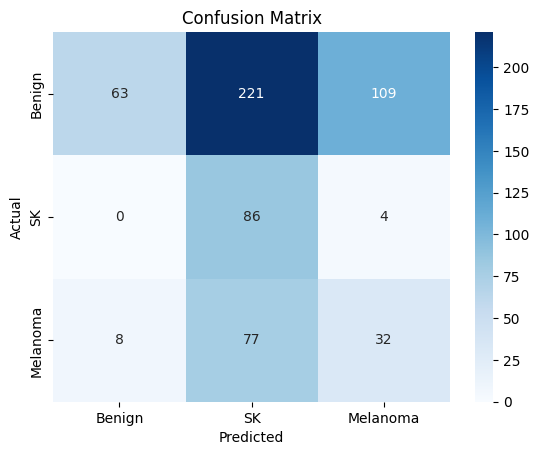


Sensitivity and Specificity per class:
Class: Benign
  Sensitivity: 0.1603
  Specificity: 0.9614
Class: SK
  Sensitivity: 0.9556
  Specificity: 0.4157
Class: Melanoma
  Sensitivity: 0.2735
  Specificity: 0.7660

AUC (macro): 0.6769
AUC (micro): 0.4905
AUC (weighted): 0.6690
Balanced Accuracy (BACC): 0.4631


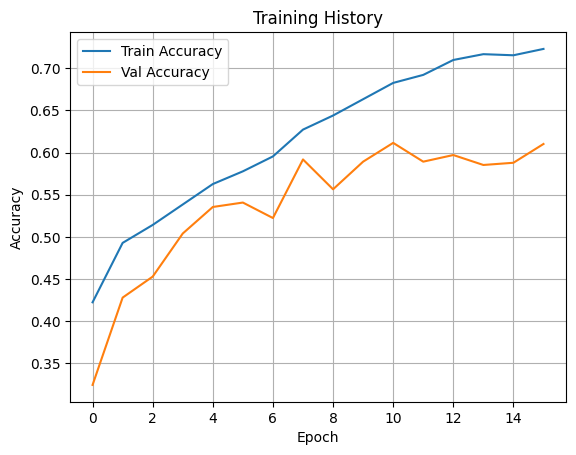

In [ ]:
#run the pipeline
main()